**Neural Collaborative filtering**

**Amazon Beauty Dataset**

In [ ]:
!pip install tensorflow==1.15.2
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 110.5MB 38kB/s 
     |████████████████████████████████| 512kB 54.1MB/s 
     |████████████████████████████████| 3.8MB 57.0MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=8d8fa53c8bb7a55b77e2f97d830b08bf86496f9926c294d52180bd152cc66a87
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

**Clonning Microsoft Recommenders NCF Model**

In [ ]:
!git clone https://github.com/Microsoft/Recommenders


Cloning into 'Recommenders'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 23470 (delta 6), reused 2 (delta 1), pack-reused 23441
Receiving objects: 100% (23470/23470), 101.52 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (15208/15208), done.


In [ ]:
import sys
sys.path.append('/content/Recommenders')

In [ ]:
import reco_utils
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/Recommenders']


In [ ]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import time
from reco_utils.dataset.python_splitters import python_random_split
from reco_utils.recommender.ncf.dataset import Dataset as NCFDataset
from reco_utils.recommender.ncf.ncf_singlenode import NCF

**Importing Amazon Luxury Beauty Dataset**

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz

--2020-08-10 07:41:56--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7356868 (7.0M) [application/octet-stream]
Saving to: ‘Luxury_Beauty_5.json.gz’

Luxury_Beauty_5.jso 100%[===================>]   7.02M  19.7MB/s    in 0.4s    

2020-08-10 07:41:57 (19.7 MB/s) - ‘Luxury_Beauty_5.json.gz’ saved [7356868/7356868]



In [ ]:
#Importing data from json file and converting to dataframe
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Luxury_Beauty_5.json.gz')

**Data Visualization**

In [ ]:
print("The number of rows in the dataset is: ", len(df))
print("The amazon pantry dataset is: \n", df.head())

The number of rows in the dataset is:  34278
The amazon pantry dataset is: 
    overall  verified   reviewTime  ... unixReviewTime vote image
0      5.0      True   01 5, 2018  ...     1515110400  NaN   NaN
1      5.0      True   04 5, 2017  ...     1491350400  NaN   NaN
2      5.0      True  03 27, 2017  ...     1490572800  NaN   NaN
3      5.0      True  03 20, 2017  ...     1489968000  NaN   NaN
4      5.0      True  02 28, 2017  ...     1488240000  NaN   NaN

[5 rows x 12 columns]


In [ ]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN


**Splitting the data to Test and Train**

In [ ]:
# df = df.sample(n=10000)
train, test = python_random_split(df, ratio=0.8)
train.head()
test.head()


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
27291,4.0,False,"11 8, 2016",A28I98PKHZZKVB,B00NM75BX4,NaN,S.Trasny,DH got his first bottle of Baxter of Californi...,2nd To Baxter's Super Close Shave Formula,1478563200,NaN,NaN
16095,5.0,True,"09 3, 2013",AQO3WDKL8Q7BL,B004N2SQUC,NaN,Nancy S,"I am loving this color. It's a pretty red, wi...",CND Hollywood,1378166400,NaN,NaN
15270,5.0,True,"07 7, 2014",A27OOJSY1RH1O6,B003OGV7UO,{'Color:': ' Powder My Nose'},A-Lo,Terrific nude color!,Five Stars,1404691200,3,NaN
29903,1.0,False,"08 24, 2017",A29E6HV2DT7RCI,B017UMXLTM,NaN,Onecutepoohbear,Felt like baby oil. Very heavy on the skin. Br...,Broke my face out,1503532800,NaN,NaN
9253,5.0,True,"06 11, 2015",A3K7RVCWO9MZQL,B0015Z90NC,NaN,carina,It is useful as it described.,Five Stars,1433980800,NaN,NaN


**Setting the Model Parameters**

In [ ]:
data = NCFDataset(train=train, test=test, seed=52, col_user='reviewerID', col_item='asin', col_rating='overall', 
                  col_timestamp='unixReviewTime', n_neg=10, n_neg_test=3)
print("n_users is: ", data.n_users)
print("n_items is: ", data.n_items)

n_users is:  3819
n_items is:  1581


In [ ]:
# Setting Model parameters such as: Model Type, batch size, layers,  
# Model parameters
EPOCHS = 200
BATCH_SIZE = 60

model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Train the NCF model**

In [ ]:
# Training the Model
start_time = time.time()
model.fit(data)
train_time = time.time() - start_time

print("The new time taken to train the Model with epoch:200 batch:60 ", train_time)

The new time taken to train the Model with epoch:200 batch:60  1432.7290880680084


In [ ]:
start_time = time.time()

users, items, preds = [], [], []
item = list(train.asin.unique())
for user in train.reviewerID.unique():
    user = [user] * len(item) 
    users.extend(user)
    items.extend(item)
    preds.extend(list(model.predict(user, item, is_list=True)))

all_predictions = pd.DataFrame(data={"reviewerID": users, "asin":items, "prediction":preds})

merged = pd.merge(train, all_predictions, on=["reviewerID", "asin"], how="outer")

test_time = time.time() - start_time
print("Took {} seconds for prediction.".format(test_time))

Took 10.372838497161865 seconds for prediction.


**Ratings Prediction**

In [ ]:
print(all_predictions.head())

       reviewerID        asin  prediction
0  A2F244OGTONA15  B00B59AULY    0.999960
1  A2F244OGTONA15  B00LA5NKTM    0.000000
2  A2F244OGTONA15  B003OGV7UO    0.000031
3  A2F244OGTONA15  B0013U0EYI    0.000000
4  A2F244OGTONA15  B00I1BLUC2    0.000000


In [ ]:
print(merged.head())

   overall verified   reviewTime  ... image prediction scaled_rating
0      5.0     True  03 12, 2016  ...   NaN   0.999960           1.0
1      5.0    False  12 11, 2016  ...   NaN   0.314664           1.0
2      5.0     True  01 19, 2015  ...   NaN   0.999970           1.0
3      5.0     True  01 19, 2015  ...   NaN   0.999970           1.0
4      5.0     True  01 19, 2015  ...   NaN   0.999970           1.0

[5 rows x 14 columns]


In [ ]:
pred_review = merged.reviewerID == 'A2F244OGTONA15'
print(len(pred_review))
print(pred_review)

27422
0         True
1        False
2        False
3        False
4        False
         ...  
27417    False
27418    False
27419    False
27420    False
27421    False
Name: reviewerID, Length: 27422, dtype: bool


**Actual rating v/s Predicted ratings**

In [ ]:
min_rating = min(merged["overall"])
max_rating = max(merged["overall"])
print(min_rating)
print(max_rating)

1.0
5.0


In [ ]:
scaled_rating = merged["overall"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

merged["scaled_rating"] = scaled_rating
merged = merged[~merged['scaled_rating'].isnull()]
merged = merged[~merged['prediction'].isnull()]

print(merged)

       overall verified   reviewTime  ... image prediction scaled_rating
0          5.0     True  03 12, 2016  ...   NaN   0.999960          1.00
1          5.0    False  12 11, 2016  ...   NaN   0.314664          1.00
2          5.0     True  01 19, 2015  ...   NaN   0.999970          1.00
3          5.0     True  01 19, 2015  ...   NaN   0.999970          1.00
4          5.0     True  01 19, 2015  ...   NaN   0.999970          1.00
...        ...      ...          ...  ...   ...        ...           ...
27417      5.0     True   10 5, 2016  ...   NaN   0.999605          1.00
27418      5.0     True  10 18, 2016  ...   NaN   0.987909          1.00
27419      4.0    False  08 20, 2014  ...   NaN   0.997790          0.75
27420      4.0    False  04 28, 2015  ...   NaN   0.588829          0.75
27421      5.0     True   10 5, 2016  ...   NaN   0.645505          1.00

[27422 rows x 14 columns]


In [ ]:
specific_col_merged = merged[['overall', 'reviewerID', 'asin', 'prediction', 'scaled_rating']]
user_item_prediction = specific_col_merged[merged.reviewerID.eq('A2F244OGTONA15')]
user_item_prediction = user_item_prediction[~user_item_prediction['overall'].isnull()]

print(len(user_item_prediction))
print("user_item_prediction \n", user_item_prediction)


8
user_item_prediction 
        overall      reviewerID        asin  prediction  scaled_rating
0          5.0  A2F244OGTONA15  B00B59AULY    0.999960            1.0
2893       5.0  A2F244OGTONA15  B00BXS9PFE    0.995652            1.0
3562       5.0  A2F244OGTONA15  B000J4FGAG    0.999410            1.0
7435       5.0  A2F244OGTONA15  B0006PLMFQ    0.999335            1.0
14245      5.0  A2F244OGTONA15  B00DTH63P2    0.996381            1.0
17020      5.0  A2F244OGTONA15  B00699JDKY    0.995916            1.0
19712      5.0  A2F244OGTONA15  B0058TE4WI    0.997323            1.0
24770      5.0  A2F244OGTONA15  B007PORYUI    0.998536            1.0


**Evaluation**

In [ ]:
from reco_utils.common.notebook_utils import is_jupyter
from reco_utils.dataset.python_splitters import python_chrono_split
from reco_utils.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
TOP_K = 10

rmse = rmse(merged, merged, col_user='reviewerID', col_item='asin', col_rating='scaled_rating', col_prediction='prediction')
mae = mae(merged, merged, col_user='reviewerID', col_item='asin', col_rating='scaled_rating', col_prediction='prediction')
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K, col_user='reviewerID', 
                    col_item='asin', col_rating='overall')
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K, col_user='reviewerID', 
                    col_item='asin', col_rating='overall')
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K, col_user='reviewerID', 
                    col_item='asin', col_rating='overall')
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K, col_user='reviewerID', 
                    col_item='asin', col_rating='overall')

print("RMSE:\t%f" % rmse,
      "MAE:\t%f" % mae,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

RMSE:	0.245540
MAE:	0.134500
MAP:	0.267145
NDCG:	0.298105
Precision@K:	0.084311
Recall@K:	0.409960


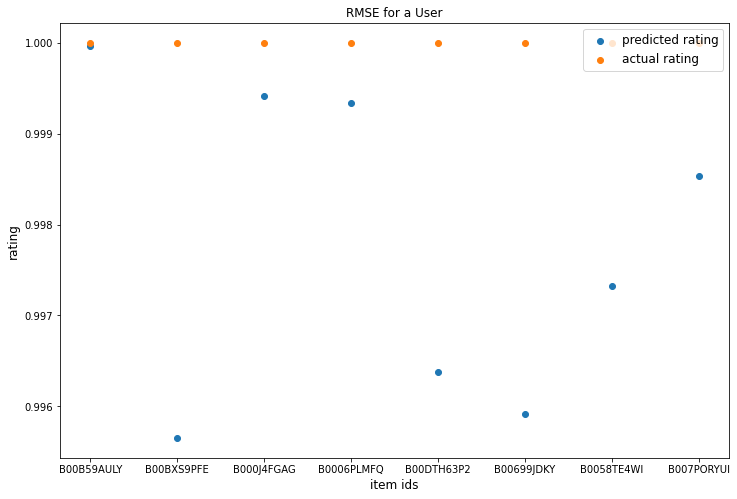

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = user_item_prediction['prediction']
x1 = user_item_prediction['scaled_rating']
y = user_item_prediction['asin']

plt.figure(figsize=(12,8))
plt.title("RMSE for a User")
plt.ylabel("rating", fontsize='large')
plt.xlabel("item ids", fontsize='large')

plt.scatter(y, x)
plt.scatter(y, x1)
plt.legend(["predicted rating", "actual rating"], loc='upper right', bbox_to_anchor=(1, 1), fontsize='large')
plt.show()